In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
import seaborn as sns
import os, time, re, random
from scipy import stats, io

import cobra
from cobra import Model, Reaction, Metabolite, flux_analysis

import warnings
warnings.filterwarnings('ignore')

In [2]:
# setup
pal4 = sns.color_palette("mako",4)
pal3 = sns.color_palette("mako",3)
pal2 = [sns.color_palette("mako",4)[3],sns.color_palette("mako",4)[0]]
pal22 = [sns.color_palette("mako",4)[0],sns.color_palette("mako",4)[3]]

folder = '../data/'

cols_rename = ['CPB_ctrl_1','CPB_ctrl_2','CPB_ctrl_3',
               'CPB_tre_1','CPB_tre_2','CPB_tre_3',
               'PVY_ctrl_1','PVY_ctrl_2','PVY_ctrl_3',
               'PVY_tre_1','PVY_tre_2','PVY_tre_3',
              ]

## functions
def flatten(t):
    return [item for sublist in t for item in sublist]

def fix_pvals(x):
    if x < 1e-16:
        x=1e-16
    return x

def linfit(x, y, xnew):
    """line fitting on log-log scale"""
    k, m = np.polyfit(x, y, 1)
    return m * xnew**(k)

def powerfit(x, y, xnew):
    """line fitting on log-log scale"""
    k, m = np.polyfit(np.log(x), np.log(y), 1)
    return np.exp(m) * xnew**(k)


In [3]:
# load 
df_test = pd.read_csv(folder+'2nd_met_annotations_table-15_4_25.tsv', sep='\t')
print(df_test.shape)

df_rxns = pd.read_excel(folder+'curatedPotatoGEM_annotation_table.xlsx')
df_rxns['pws'] = df_rxns.Pathway.str.split('|')
print(df_rxns.shape)
print(df_rxns.pws.dropna().shape)
print(df_rxns.blocked.sum())

# model
model = cobra.io.read_sbml_model(folder+'curatedPotatoGEM.xml')
model


(137, 12)
(7092, 35)
(1056,)
67
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-16


Name,model
Memory address,1da4f674f50
Number of metabolites,3801
Number of reactions,7092
Number of genes,2173
Number of groups,0
Objective expression,1.0*Bio_Stu_leaf - 1.0*Bio_Stu_leaf_reverse_466da
Compartments,"c, h, hm, x, m, r, g, pm, cut, ohm, mm, ob, imm, l, rm, pg"


In [4]:
# load model files to count num matched tr
mat1 = io.loadmat(folder+'C_1_tre_trmodel_v22.mat')
print(mat1['matchedTr'].shape[0])
mat2 = io.loadmat(folder+'Rywal_wilga_2_poolA_STAR_trmodel_v22.mat')
print(mat2['matchedTr'].shape[0])

tmp1 = mat1['matchedTr'][:,1]
tmp1 = (pd.DataFrame(tmp1,columns=['gpr'])
       .astype(str)
       .gpr.str.split(' or ')
       .explode()
       .unique()
      )
print(tmp1.shape[0])


tmp2 = mat2['matchedTr'][:,1]
tmp2 = (pd.DataFrame(tmp2,columns=['gpr'])
       .astype(str)
       .gpr.str.split(' or ')
       .explode()
       .unique()
      )
print(tmp2.shape[0])

# read essential
essential_opt = pd.read_csv(folder+'essential_25_4_25.csv')['0']
print(essential_opt.shape)

# how many essential overlap
tmpr1 = mat1['matchedTr'][:,0]
tmpr1 = (pd.DataFrame(tmpr1,columns=['rxn'])
        .rxn.apply(lambda x: str(x[0]))
      )
print(tmpr1.isin(essential_opt).sum())

tmpr2 = mat2['matchedTr'][:,0]
tmpr2 = (pd.DataFrame(tmpr2,columns=['rxn'])
        .rxn.apply(lambda x: str(x[0]))
      )
print(tmpr2.isin(essential_opt).sum())

# global average
print((tmpr1.isin(essential_opt).sum()+tmpr2.isin(essential_opt).sum())/
      (mat1['matchedTr'].shape[0]+mat2['matchedTr'].shape[0]))
print(essential_opt.shape[0]/len(model.reactions))

# enrichment test proportion of essential GPR-annotated
# compared to proportion of global essential
conting = [[(267+272)/2,essential_opt.shape[0]],
           [(3140+3207)/2,len(model.reactions)]]
print(conting)
print(stats.fisher_exact(conting,alternative='two-sided'))


3140
3207
2440
2500
(439,)
267
277
0.08570978414999213
0.06190073322053018
[[269.5, 439], [3173.5, 7092]]
SignificanceResult(statistic=np.float64(1.369576875502083), pvalue=np.float64(0.00011422447974749155))


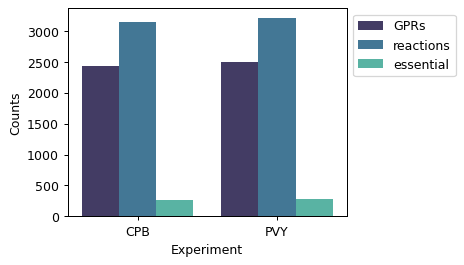

In [5]:
# supp. figure 

df_plot = (pd.DataFrame([
         ['GPRs',tmp1.shape[0],tmp2.shape[0]],
         ['reactions',mat1['matchedTr'].shape[0],mat2['matchedTr'].shape[0]],
         ['essential',tmpr1.isin(essential_opt).sum(),tmpr2.isin(essential_opt).sum()]
        ],columns=['type','cpb','pvy'])
           .melt(id_vars=['type'],value_vars=['cpb','pvy'])
          )

mpl.rcParams['figure.dpi'] = 90
plt.figure(figsize=(4,3))
sns.barplot(data=df_plot,
            x='variable',y='value',hue='type',
            palette=pal3
           )
plt.xlabel('Experiment')
plt.ylabel('Counts')
plt.xticks((0,1),['CPB','PVY'])
plt.legend(bbox_to_anchor=(1,1)) 


3140 3207
(8427, 36) 6055
(2372, 36) 0
(3140,) (3207,) 3240


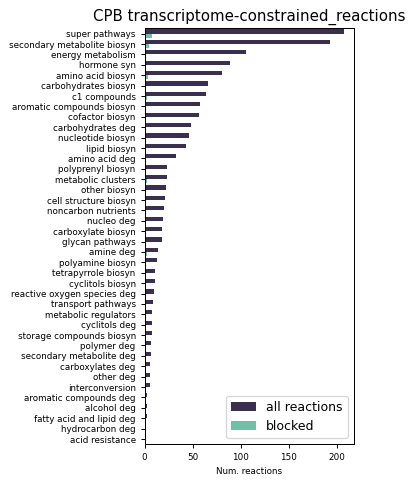

0.9574468085106383


In [6]:
# supplement figures

# get only GPR subset of rxns
tmp1 = mat1['matchedTr'][:,0]
tmp1 = (pd.DataFrame(tmp1,columns=['rxn'])
        .rxn.apply(lambda x: str(x[0]))
      )
tmp1

tmp2 = mat2['matchedTr'][:,0]
tmp2 = (pd.DataFrame(tmp2,columns=['rxn'])
        .rxn.apply(lambda x: str(x[0]))
      )
tmp2

# sanity check
print(df_rxns.Abbreviation.isin(tmp1).sum(),
        df_rxns.Abbreviation.isin(tmp2).sum())

# prepare table
df_rxns2 = df_rxns.copy(deep=True)
df_rxns2['ontology'] = df_rxns2.Ontology.str.split('|')
df_rxns2 = df_rxns2.explode('ontology')
print(df_rxns2.shape, df_rxns2['ontology'].isna().sum())
df_rxns2 = df_rxns2.dropna(subset=['ontology'])
print(df_rxns2.shape, df_rxns2['ontology'].isna().sum())

# add TF cols
df_rxns2['isin_cpb'] = df_rxns2.Abbreviation.isin(tmp1)
df_rxns2['isin_pvy'] = df_rxns2.Abbreviation.isin(tmp2)

# combine superset
tmp12 = list(set(tmp1).union(set(tmp2)))
print(tmp1.shape,tmp2.shape,len(tmp12))
df_rxns2['isin_both'] = df_rxns2.Abbreviation.isin(tmp12)

# add blocked
tmp = (df_rxns2[df_rxns2.isin_cpb]
       .groupby('ontology')
       .Abbreviation.count()
       .rename('all')
       .reset_index()
       .merge(df_rxns2[df_rxns2.isin_cpb].query('blocked==True')
              .groupby('ontology')
              .Abbreviation.count()
              .rename('blocked')
              .reset_index(),
              on='ontology',how='left'
             )
      .fillna(0)
       .sort_values(by=['all'],ascending=False)
      )
tmp

plt.figure(figsize=(3,6))
sns.barplot(data=tmp.melt(id_vars='ontology',value_vars=['all','blocked']),
            y='ontology',x='value',
            hue='variable',palette=pal22
           )
plt.xlabel('Num. reactions',fontsize=7)
#plt.xscale('log')
L = plt.legend(loc='lower right')
L.get_texts()[0].set_text('all reactions')
L.get_texts()[1].set_text('blocked')
plt.ylabel('')
plt.tick_params(labelsize=7)
plt.ylim(39.5,-0.5)
plt.title('CPB transcriptome-constrained_reactions')
plt.show()

# compared to fig1c
tmp2 = set(pd.read_csv(folder+'unique_ontologies.csv').ontology.unique())
print(len(set(tmp.ontology.unique()).intersection(tmp2))/len(tmp2))


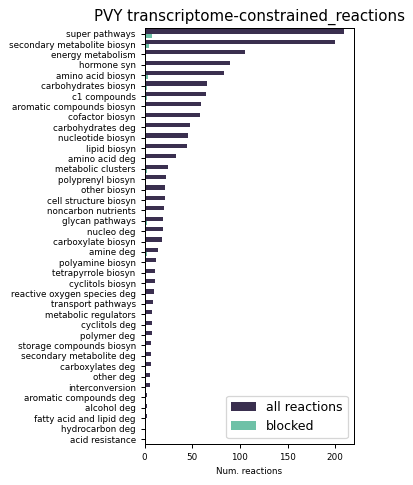

0.9574468085106383


In [7]:
# plot
# add blocked
tmp = (df_rxns2[df_rxns2.isin_pvy]
       .groupby('ontology')
       .Abbreviation.count()
       .rename('all')
       .reset_index()
       .merge(df_rxns2[df_rxns2.isin_pvy].query('blocked==True')
              .groupby('ontology')
              .Abbreviation.count()
              .rename('blocked')
              .reset_index(),
              on='ontology',how='left'
             )
      .fillna(0)
       .sort_values(by=['all'],ascending=False)
      )
tmp

plt.figure(figsize=(3,6))
sns.barplot(data=tmp.melt(id_vars='ontology',value_vars=['all','blocked']),
            y='ontology',x='value',
            hue='variable',palette=pal22
           )
plt.xlabel('Num. reactions',fontsize=7)
L = plt.legend(loc='lower right')
L.get_texts()[0].set_text('all reactions')
L.get_texts()[1].set_text('blocked')
plt.ylabel('')
plt.tick_params(labelsize=7)
plt.ylim(39.5,-0.5)
plt.title('PVY transcriptome-constrained_reactions')
plt.show()

# compared to fig1c
print(len(set(tmp.ontology.unique()).intersection(tmp2))/len(tmp2))


3140 3207
(277,)
(2963,)
(37948, 7) (25120, 7) (12828, 7)


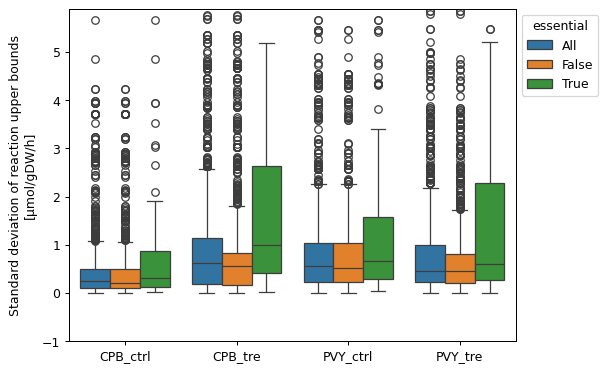

In [8]:
# supplement - variability across rxn types

# get only GPR subset of rxns
tmp1 = mat1['matchedTr'][:,0]
tmp1 = (pd.DataFrame(tmp1,columns=['rxn'])
        .rxn.apply(lambda x: str(x[0]))
      )
tmp2 = mat2['matchedTr'][:,0]
tmp2 = (pd.DataFrame(tmp2,columns=['rxn'])
        .rxn.apply(lambda x: str(x[0]))
      )

# sanity check
print(df_rxns.Abbreviation.isin(tmp1).sum(),
        df_rxns.Abbreviation.isin(tmp2).sum())

# superset of essential rxns
all_12 = pd.Series(tmp12)
ess_12 = pd.Series(tmp12)[pd.Series(tmp12).isin(essential_opt)]
print(ess_12.shape)
non_12 = pd.Series(tmp12)[~pd.Series(tmp12).isin(essential_opt)]
print(non_12.shape)

# load ub
df_ub = pd.read_csv(folder+'constrained_models_ub.csv',
                   names=cols_rename)
df_mat = pd.read_csv(folder+'constrained_model_rxns.csv',
                    header=None)[0].rename('geneID').str.strip("'")
df_ub.index = df_mat
df_ub

# mark essential rxns TF
tmp = essential_opt[essential_opt.isin(df_mat)]
df_ub['essential'] = False
df_ub.loc[tmp,'essential'] = True
df_ub

df_ub1 = df_ub.loc[tmp1][cols_rename[:8]]
df_ub1['essential'] = df_ub.loc[tmp1].essential.values
df_ub1 = df_ub1.reset_index().melt(id_vars=['geneID','essential'],value_vars=cols_rename[:8])
df_ub1['exp'] = df_ub1.variable.apply(lambda x: x.split('_')[0])
df_ub1['type'] = df_ub1.variable.apply(lambda x: x.split('_')[1])
df_ub1['rep'] = df_ub1.variable.apply(lambda x: x.split('_')[2])
df_ub1

df_ub2 = df_ub.loc[tmp2][cols_rename[8:]]
df_ub2['essential'] = df_ub.loc[tmp2].essential.values
df_ub2 = df_ub2.reset_index().melt(id_vars=['geneID','essential'],value_vars=cols_rename[8:])
df_ub2['exp'] = df_ub2.variable.apply(lambda x: x.split('_')[0])
df_ub2['type'] = df_ub2.variable.apply(lambda x: x.split('_')[1])
df_ub2['rep'] = df_ub2.variable.apply(lambda x: x.split('_')[2])
df_ub2

df_ub = pd.concat([df_ub1,df_ub2])
print(df_ub.shape, df_ub1.shape, df_ub2.shape)
df_ub

# plot
df_plot = (df_ub
            .groupby(['exp','type','essential','geneID'])
            .value.std()
            .reset_index()
)

df_plot['x'] = df_plot.exp+'_'+df_plot.type
df_plot['essential'] = df_plot.essential.astype(str)
df_plot1 = df_plot.copy(deep=True)
df_plot2 = df_plot.copy(deep=True)
df_plot1['essential'] = 'All'
df_plot = pd.concat([df_plot1,df_plot2])
df_plot

# plot
mpl.rcParams['figure.dpi'] = 90
sns.boxplot(data=df_plot.reset_index(),
            x='x',hue='essential',y='value',
            #kind='box'
           )
plt.ylim(-1,5.9)
plt.legend(title='essential',
           bbox_to_anchor=(1,1))
plt.xlabel('')
plt.ylabel('Standard deviation of reaction upper bounds\n[μmol/gDW/h]')
plt.show()


In [9]:
# text values 
tmp = (df_ub.groupby(['exp','type','essential','geneID'])
     .value.std()
     .reset_index()
     .groupby(['exp','type',])
     .value.median()
)

print(tmp.loc['CPB','tre']/tmp.loc['CPB','ctrl'])
print(tmp.loc['PVY','tre']/tmp.loc['PVY','ctrl'])
print(tmp.loc['PVY','ctrl']/tmp.loc['CPB','ctrl'])
print(tmp.loc['PVY','tre']/tmp.loc['CPB','tre'])

# significance of difference across types
tmp = (df_ub.groupby(['exp','type','essential','geneID'])
     .value.std()
     .reset_index(level=[2,3],drop=True)
)
xx = tmp.loc['CPB','tre']
yy = tmp.loc['CPB','ctrl']
print(stats.ranksums(xx, yy))


2.4990845702905675
0.7908056235769708
2.3001055511554367
0.7278410768079131
RanksumsResult(statistic=np.float64(22.99926342417643), pvalue=np.float64(4.7410644701881266e-117))


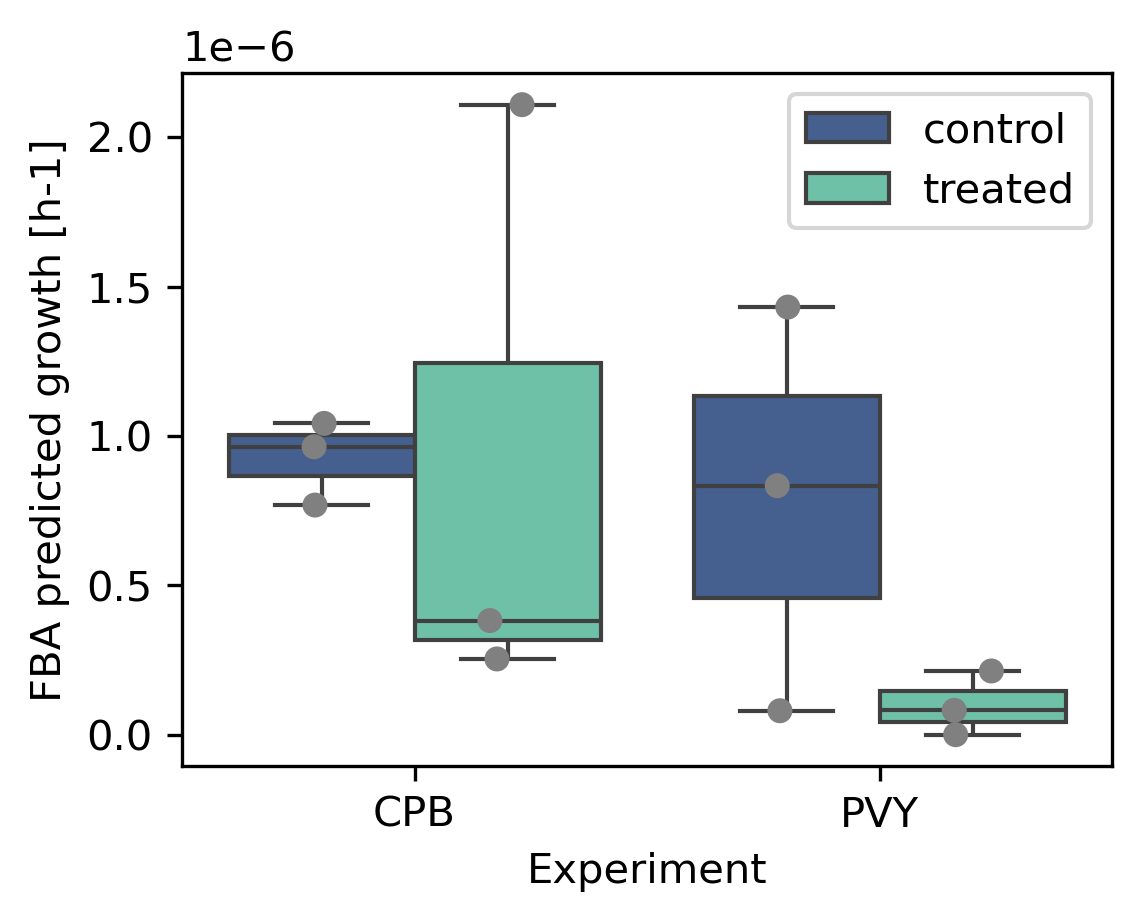

In [10]:
# Fig 5E

df_plot = (pd.read_csv(folder+'constrained_models_fba.csv',
                     names=cols_rename)
           .transpose()
           .reset_index()
          )
df_plot.columns=['tmp','fba']
df_plot['exp'] = df_plot.tmp.apply(lambda x: x.split('_')[0])
df_plot['type'] = df_plot.tmp.apply(lambda x: x.split('_')[1])
df_plot['rep'] = df_plot.tmp.apply(lambda x: x.split('_')[2])
df_plot

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(4,3))
ax = sns.boxplot(data=df_plot.replace({'type':{'ctrl':'control',
                                          'tre':'treated'}}),
           x='exp',hue='type',y='fba',
            palette=[sns.color_palette("mako",4)[1],sns.color_palette("mako",4)[3]],
           )
sns.stripplot(data=df_plot.replace({'type':{'ctrl':'control',
                                          'tre':'treated'}}),
              dodge=True, ax=ax,legend=False,
           x='exp',hue='type',y='fba',
            palette=['grey','grey'], size = 6
           )
plt.xlabel('Experiment')
plt.ylabel('FBA predicted growth [h-1]')
plt.legend(title='')
plt.show()


In [11]:
# G-D ratio
df_plot.groupby(['exp','type']).fba.describe()
tmp = df_plot.groupby(['exp','type']).fba.median()
print(tmp.iloc[1]/tmp.iloc[0])
print(tmp.iloc[3]/tmp.iloc[2])

# average perc. decrease
print(1-(tmp.iloc[1]/tmp.iloc[0] + tmp.iloc[3]/tmp.iloc[2])/2)


0.3963577876932656
0.09785084298314034
0.752895684661797


(3474, 35)
count    3474.000000
mean        5.356649
std         9.548686
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        82.000000
Name: gene_id, dtype: float64
2.0


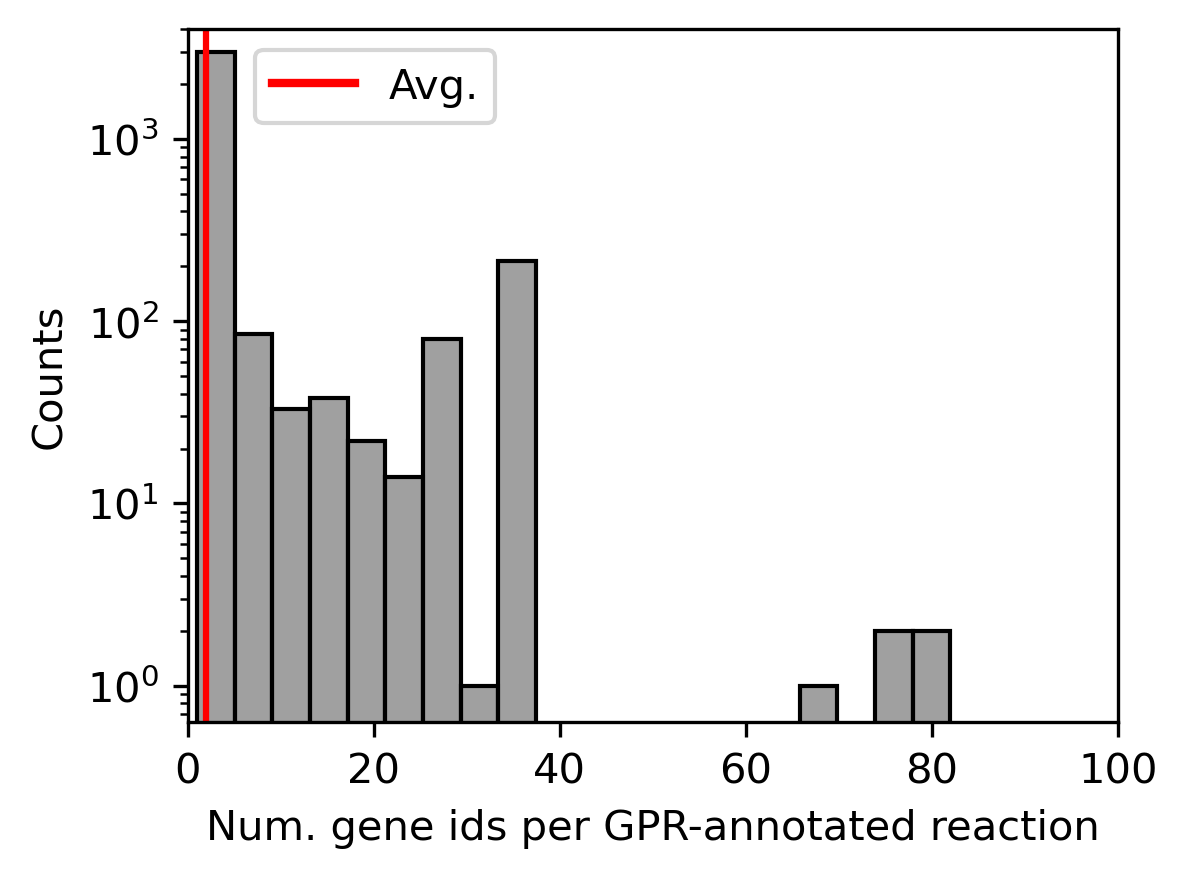

In [12]:
# Fig 5b
# GPR rules analysis

# gpr subset
df_gpr = df_rxns.dropna(subset='GPR')
print(df_gpr.shape)
df_gpr['gene_id'] = (df_gpr.GPR
 .str.split(' or ')
 .apply(lambda x: [xx.split(' and ') for xx in x])
 .apply(lambda x: flatten(x))
 .apply(lambda x: [xx.replace('(','').replace(')','') for xx in x]) # cleanup
 .apply(lambda x: [xx.strip(' ') for xx in x])
)

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(4,3))
print(df_gpr.gene_id.apply(lambda x: len(set(x))).describe())
sns.histplot(data=df_gpr.gene_id.apply(lambda x: len(set(x))),
             bins=20,fill=True,
             color='gray'
            )
tmp = df_gpr.gene_id.apply(lambda x: len(set(x))).median()
print(tmp)
plt.plot((tmp,tmp),(0,1e4),c='r')
plt.yscale('log')
plt.xlim(0,100)
plt.ylim(0,4e3)
plt.xlabel('Num. gene ids per GPR-annotated reaction')
plt.ylabel('Counts')

custom_lines = [Line2D([0], [0], color='r', lw=2)]
plt.legend(custom_lines,['Avg.'],
           bbox_to_anchor=[0.05,1])

plt.show()


In [13]:
# ratio of gpr-annotated reactions
print(df_gpr.shape, df_rxns.shape)
print(df_gpr.shape[0]/df_rxns.shape[0])


(3474, 36) (7092, 35)
0.48984771573604063


(3474, 36) (3517, 36)
(7092, 35) (7151, 35)
  type_list         0
0  2nd met.  0.496466
1      core  0.636126
2     lipid  0.506589
3     other  0.214844
0.491819325968396 0.49646643109540634


<Figure size 1200x900 with 0 Axes>

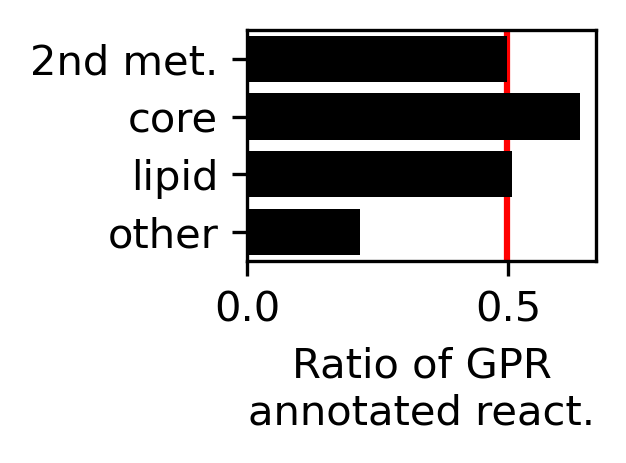

In [14]:
# num reactions from diff types annotated with GPRs
plt.figure(figsize=(4,3))
df_rxns['type_list'] = df_rxns.type_full.str.split('|')
df_gpr['type_list'] = df_gpr.type_full.str.split('|')
df_gprt = df_gpr.explode('type_list')
print(df_gpr.shape, df_gprt.shape)
df_rxnst = df_rxns.explode('type_list')
print(df_rxns.shape, df_rxnst.shape)

df_plot = (df_gprt.groupby('type_list')
           .gene_id.count()
           .divide(df_rxnst.groupby('type_list').Abbreviation.count())
           .reset_index()
)
print(df_plot)

# avg
gpr_avg = (df_gprt.gene_id.count()
           /df_rxnst.Abbreviation.count())
sec_avg = df_plot.values[0][1]
print(gpr_avg,sec_avg)

#
plt.figure(figsize=[1.5,1])
sns.barplot(data=df_plot,x=0,y='type_list',#color='k')
            color='k') #pal2[1])
plt.plot((sec_avg,sec_avg),(-5,5),'r',zorder=0)
plt.ylim(3.5,-0.5)
plt.xlabel('Ratio of GPR\nannotated react.')
plt.ylabel('')
plt.show()


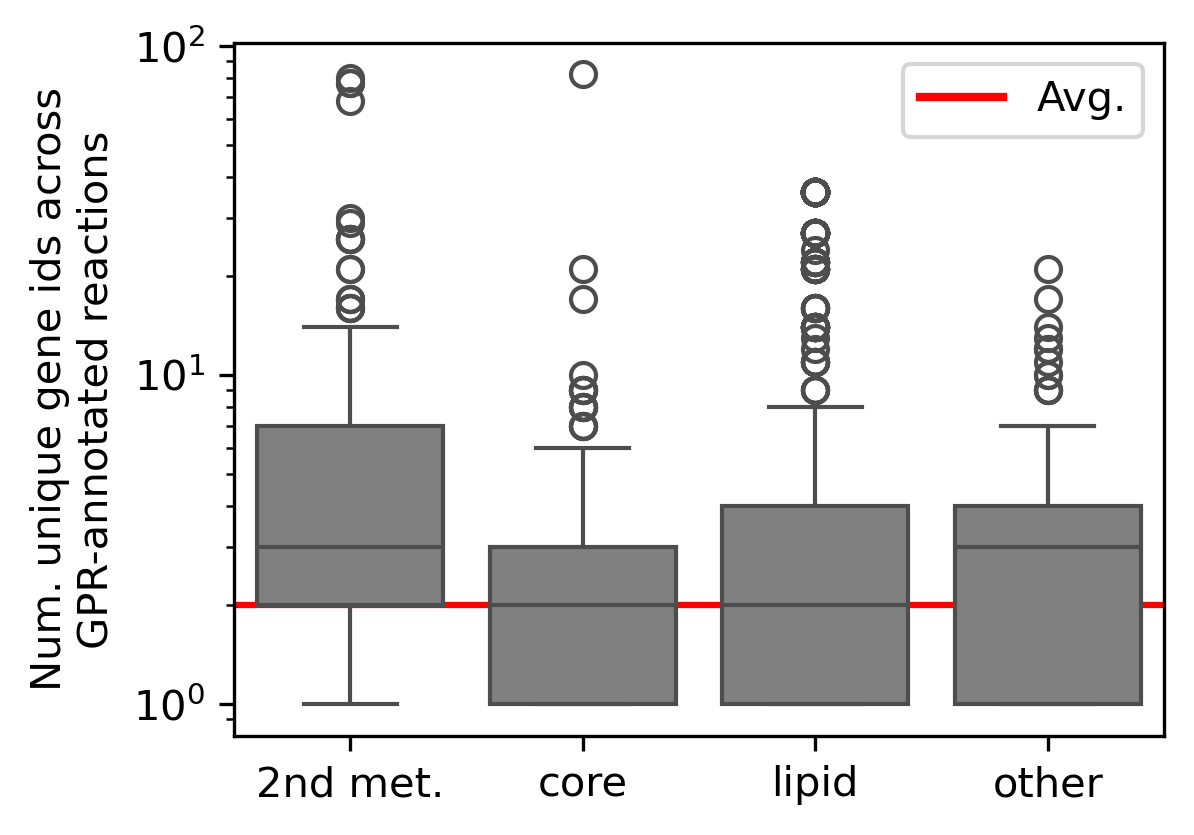

In [15]:
# num gene ids across types
plt.figure(figsize=(4,3))

df_plot = (df_gprt.groupby(['type_list','Abbreviation'])
           .gene_id.apply(lambda x: len(set(flatten(x))))
           .rename('counts')
           .reset_index()
          )
df_plot

ax = sns.boxplot(data=df_plot,
                 x='type_list',y='counts',
                 color='gray')
plt.ylabel('Num. unique gene ids across\nGPR-annotated reactions')
plt.xlabel('')
plt.yscale('log')

# add average
plt.plot((-10,10),(df_plot.counts.median(),df_plot.counts.median()),'r',zorder=0)
custom_lines = [Line2D([0], [0], color='r', lw=2)]
plt.legend(custom_lines,['Avg.'],loc=1)
plt.xlim(-0.5,3.5)

plt.show()


In [16]:
# average increase of gene ids in second met. vs primary met.
print(df_plot.query('type_list=="2nd met."').counts.median()/
      df_plot.query('type_list!="2nd met."').counts.median())

# stats
xx = df_plot.query('type_list=="2nd met."').counts.values
yy = df_plot.query('type_list!="2nd met."').counts.values
print(stats.ranksums(xx, yy))


1.5
RanksumsResult(statistic=np.float64(7.292933138464947), pvalue=np.float64(3.032786234289372e-13))


(3426, 35)
129
(630, 35)
(777, 48)
(420, 49)
                         class2         0
0                     alkaloids  0.297297
1                      hormones  0.475309
2                         other  0.441176
3  phenylpropanoid\nderivatives  0.485531
4                    precursors  0.854369
5                    terpenoids  0.655172
6                        toxins  0.666667


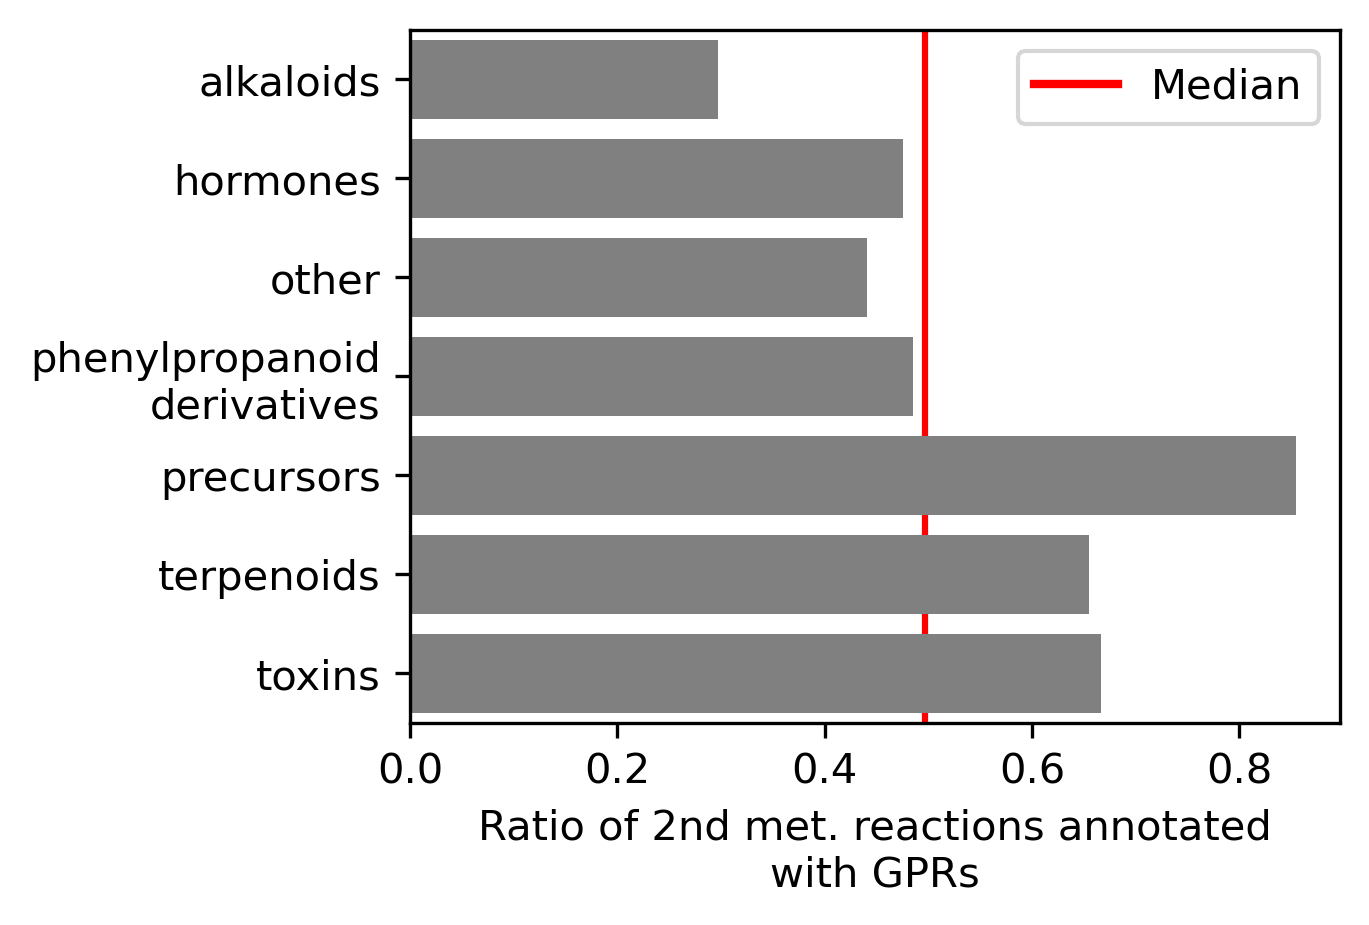

In [17]:
# split across secondary subtypes

# make new class adding precursors separately
df_test['class'].unique()
df_test['class2'] = df_test['class'].values
df_test.loc[df_test.type=='precursors','class2'] = 'precursors'
df_test['class2'].unique() # OK

# make pws exploded df
df_rxns['pws'] = df_rxns.Pathway.str.split('|')
df_rxns2 = df_rxns.dropna(subset=['pws'])
df_rxns2 = df_rxns2.explode('pws')
print(df_rxns2.shape)
tmp = df_test.biocyc_pwy.unique() # 2nd pwy subset
print(len(tmp))
print(df_rxns2.query('pws.isin(@tmp)').shape) #

# gpr subset
df_sec = (df_rxns2
          .query('pws.isin(@tmp)')
          .merge(df_test,left_on='pws',right_on='biocyc_pwy',how='left')
)
print(df_sec.shape)
df_sec2 = df_sec.dropna(subset='GPR')
df_sec2['gene_id'] = (df_sec2.GPR
 .str.split(' or ')
 .apply(lambda x: [xx.split(' and ') for xx in x])
 .apply(lambda x: flatten(x))
 .apply(lambda x: [xx.replace('(','').replace(')','') for xx in x]) # cleanup
 .apply(lambda x: [xx.strip(' ') for xx in x]) 
)
print(df_sec2.shape)

# plot
df_plot = (df_sec2.groupby('class2')
           .GPR.count()
           .divide(df_sec.groupby('class2').Abbreviation.count())
           .reset_index()
           .replace({'class2':{'phenylpropanoid derivatives':
                               'phenylpropanoid\nderivatives'
                              }})
)
print(df_plot)

# plot
plt.figure(figsize=(4,3))
sns.barplot(data=df_plot,x=0,y='class2',color='gray') #pal2[1])
plt.xlabel('Ratio of 2nd met. reactions annotated\nwith GPRs')
plt.ylabel('')

# add avg
plt.plot((sec_avg,sec_avg),(-10,10),'r',zorder=0)
plt.ylim(6.5,-0.5)
custom_lines = [Line2D([0], [0], color='r', lw=2)]
plt.legend(custom_lines,['Median'],loc=1)

plt.show()


(38, 168)
(33,)
(33, 167)
(7092, 4)
(3801, 7092)
33
(33, 5)
(33, 3)
SignificanceResult(statistic=np.float64(0.483288770053476), pvalue=np.float64(0.004384436643243206))


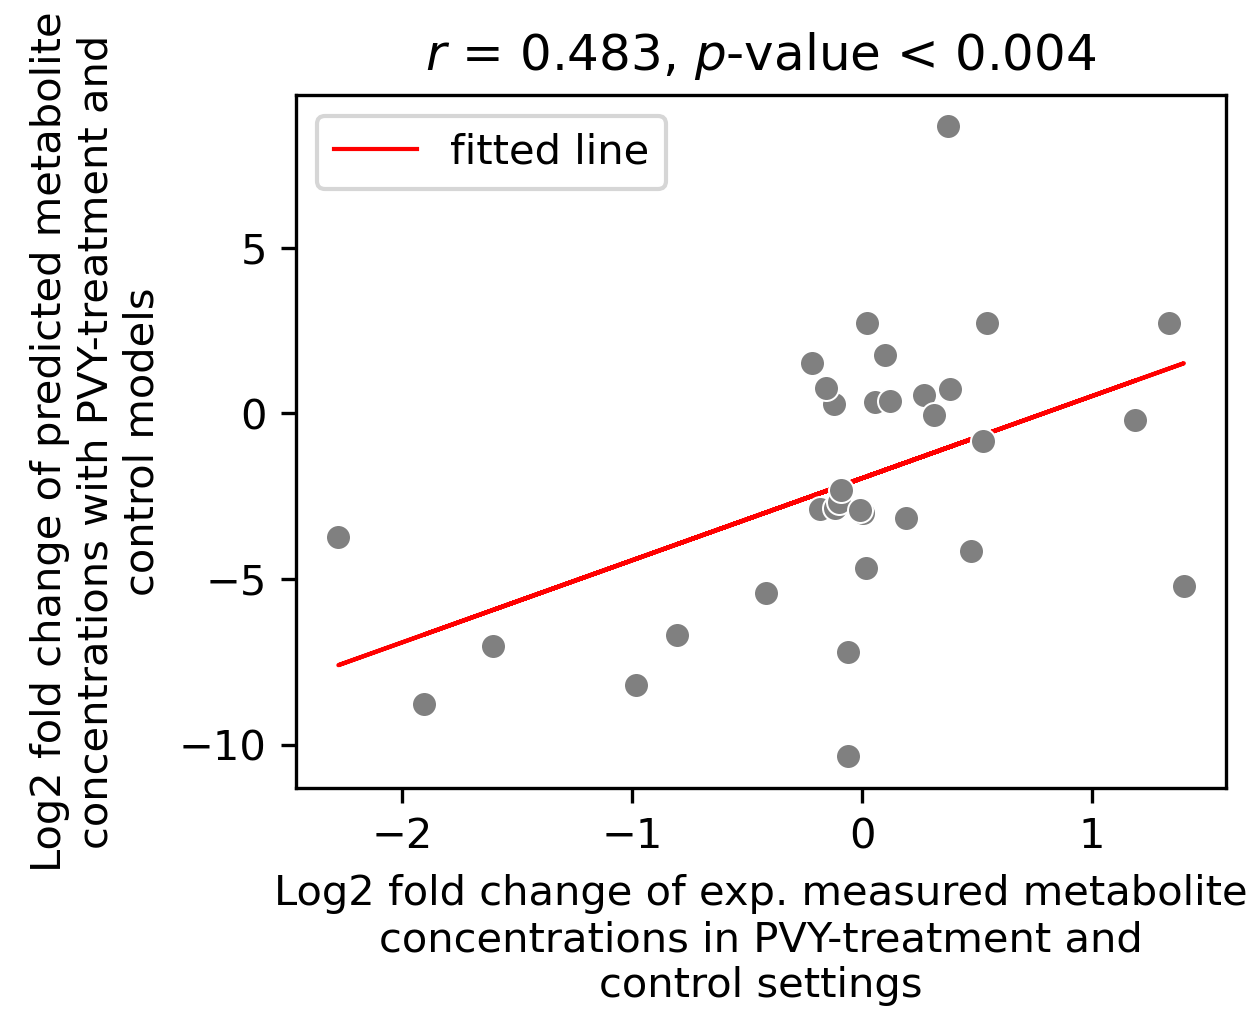

In [18]:
# Fig 5F
# metabolomics validation

# laod data
df_val = pd.read_excel(folder+'IgorPVY1__normalizirani_obdelava-metabolite_ids_added.xlsx',
                      skiprows=2).dropna(subset=['potatogem_id'])
print(df_val.shape)
df_val

# Sum up measurements at diff parameters
print(df_val.potatogem_id.unique().shape)
df_val = df_val.groupby('potatogem_id').sum()
print(df_val.shape)

# sampling medians
df_med = pd.read_csv(folder+'sampling_medians_9_5_2025.csv').set_index('Var1')
print(df_med.shape)
df_med

# compute
S = cobra.util.array.create_stoichiometric_matrix(model)
print(S.shape)
abs(S)

# find mets in model
mets = pd.Series([x.id for x in model.metabolites])
print(mets.isin(df_val.reset_index().potatogem_id).sum())
mets_ind = mets[mets.isin(df_val.reset_index().potatogem_id)]
mets_ind

# reorder
df_med = df_med.loc[[x.id for x in model.reactions]]
df_med

# matrix multiplication, account for in and out fluxes per met
mat = np.matmul(np.abs(S[mets_ind.index]),df_med.values)
df_mat = pd.DataFrame(mat,index=mets_ind.tolist(),columns=df_med.columns.tolist())
df_mat

# log ratios
eps = 1e-9 # avod div-by-0
df_mat['PVY_log2fc'] = np.log2((df_mat['PVY_tre']+eps)/(df_mat['PVY_ctrl']+eps))
print(df_mat.shape)

# plot 
df_val['mass_log2fc'] = np.log2((df_val['I-NTN-sp_3dpi']/df_val['I-S-sp_3dpi']))

df_plot = (df_val.reset_index()
           [['potatogem_id','mass_log2fc']]
           .merge(df_mat[['PVY_log2fc']],
                  left_on='potatogem_id',right_index=True,how='left')
          )
print(df_plot.dropna().shape)
df_plot

# correlation plot
plt.figure(figsize=(4,3))
x = df_plot.dropna()['mass_log2fc'].values
y = df_plot.dropna()['PVY_log2fc'].values
print(stats.spearmanr(x,y))

slope, intercept, rvalue, pvalue, stderr = stats.linregress(x,y)

sns.scatterplot(data=df_plot,y='PVY_log2fc',x='mass_log2fc', c='grey')
plt.plot(x, intercept+slope*x, 'r',label='fitted line',
       linewidth=1,zorder=0)
plt.legend(loc='upper left')

rvalue,pvalue = stats.spearmanr(x,y)
plt.title('$r$ = '+str("%.3f" % rvalue)+ ', $p$-value < '+str("%.3f" % fix_pvals(pvalue))) 
plt.ylabel('Log2 fold change of predicted metabolite\nconcentrations with PVY-treatment and\ncontrol models')
plt.xlabel('Log2 fold change of exp. measured metabolite\nconcentrations in PVY-treatment and\ncontrol settings')

plt.show()


In [19]:
# supp. table
df_plot

,potatogem_id,mass_log2fc,PVY_log2fc
0,4abut[c],0.100621,1.759857
1,5oxpro[c],-0.063325,-10.349179
2,Gal[c],0.270377,0.557748
3,adn[c],-0.182437,-2.885327
4,akg[c],0.058162,0.350729
5,ala_B[c],-0.124144,0.275512
6,ala_L[c],1.333645,2.722636
7,ascb_L[c],1.399824,-5.196558
8,asp_L[c],-0.156842,0.774327
9,cit[c],1.187169,-0.206339


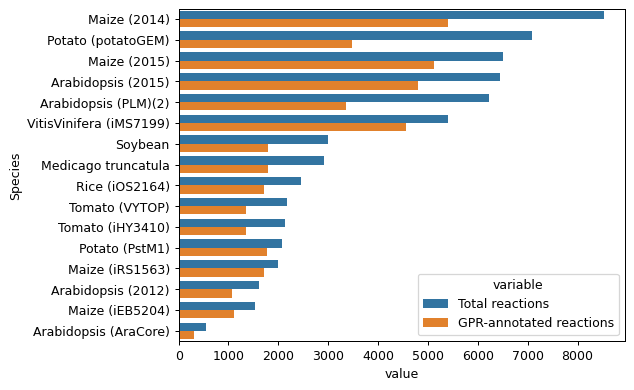

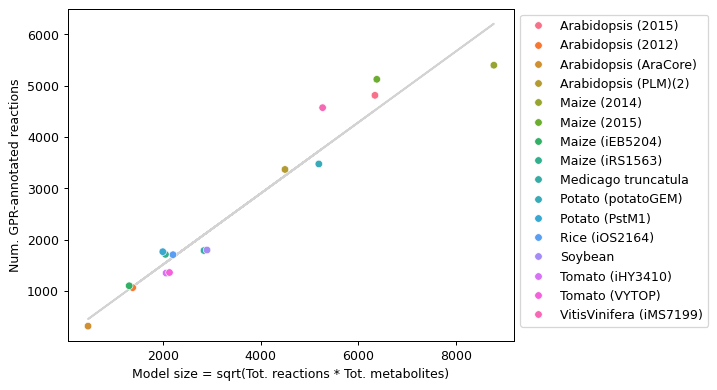

In [20]:
# published model comparisons
df = pd.read_excel(folder+'Properties_models.xlsx').iloc[:17]
df.loc[0,'Species'] = 'Arabidopsis (2015)'
df.loc[1,'Species'] = 'Arabidopsis (2012)'
df.loc[4,'Species'] = 'Maize (2014)'
df.loc[5,'Species'] = 'Maize (2015)'
df

# add num gpr-annotated
df['GPR-annotated reactions'] = df['Total reactions']*df['% Reactions with GPR rules']/100
df

# GPR proportional to model size
mpl.rcParams['figure.dpi'] = 90
sns.barplot(data=df
            .iloc[:16]
            .sort_values(by='Total reactions',ascending=False)
            .melt(id_vars='Species', value_vars=['Total reactions','GPR-annotated reactions']),
            y='Species',x='value',hue='variable',errorbar=None
           )
plt.show()

df_plot = df.iloc[:16]
df_plot['Model size'] = np.sqrt(df['Total reactions']*df['Total metabolites'])

x=df_plot['Model size']
y=df_plot['GPR-annotated reactions']
slope, intercept, rvalue, pvalue, stderr = stats.linregress(x,y)
sns.scatterplot(data=df_plot,
            y='GPR-annotated reactions',x='Model size',hue='Species',
           )
plt.plot(x, slope*x+intercept, 'lightgrey',zorder=-1)
plt.xlabel('Model size = sqrt(Tot. reactions * Tot. metabolites)')
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('Num. GPR-annotated reactions')
plt.show()
